# Projet numérique : lignes de niveau

In [1]:
import autograd
from autograd import numpy as np
import matplotlib.pyplot as plt

Exemples de fonction qui nous permettront de tester nos algorithmes :

In [2]:
def f(x,y):
    return(x**2+y**2)

def g(x,y):
    return(2*x**2+3*y)

def h(x,y):
    return(2*(np.exp(-x**2-y**2)-np.exp(-(x-1)**2-(y-1)**2)))

## Contour simple

### Amorce

D'après le théorème des valeurs intermédiaires, et par continuité de $y \rightarrow f(0,y)$, si $f(0,1) \leq c \leq f(0,0)$ ou $f(0,0) \leq c \leq f(0,1)$, alors il existe t tel que $f(0,t)=c$.
Si cette condition est remplie, on peut approcher la solution t par dichotomie.

In [3]:
def find_seed(g,c=0,eps=2**(-26)):
    a,b=0,1
    if ((g(0,1)<=c<=g(0,0)) or (g(0,0)<=c<=g(0,1))):
        while (b-a)>eps:
            if g(0,(b+a)/2)>c:
                b=(b+a)/2
            else:
                a=(b+a)/2
        return((b+a)/2)
    else:
        return None    

On peut aussi rechercher un zéro de la fonction $y \rightarrow f(0,y)-c$ à condition que sa dérivée ne s'annule pas sur $[0,1]$. Cependant cette méthode n'assure pas la convergence ou peut être peut être longue si la racine est loin du point de départ. Pour être sûr que l'algorithme termine on impose un nombre d'itération maximum.

In [4]:
def find_seed_newton(g,c=0.0,eps=2**(-26)):
    it=0
    init=0.1
    if ((g(0,1)<=c<=g(0,0)) or (g(0,0)<=c<=g(0,1))):
        def f(y):
            return(g(0,y)-c)
        Y=[init,-f(init)/autograd.grad(f)(init)]
        k=0
        while abs(Y[k]-Y[k+1])>eps and it<1000:
            Y.append(Y[k]-(f(Y[k]))/autograd.grad(f)(Y[k]))
            k+=1
            it+=1
        return Y[-1]
    else:
        return None

#### Comparaison des deux algorithmes en précision et en rapidité

In [5]:
print("Erreur avec find_seed(f,0.25)")
print(find_seed(f,0.25)-0.5)
print("Erreur avec find_seed_newton(f,0.25)")
print(find_seed_newton(f,0.25)-0.5)

print("Erreur avec find_seed(g,0.3)")
print(find_seed(g,0.3)-0.1)
print("Erreur avec find_seed_newton(g,0.3)")
print(find_seed_newton(g,0.3)-0.1)

Erreur avec find_seed(f,0.25)
7.450580596923828e-09
Erreur avec find_seed_newton(f,0.25)
5.37225819385867e-12
Erreur avec find_seed(g,0.3)
1.4901161138336505e-09
Erreur avec find_seed_newton(g,0.3)
0.0


L'algorithme qui utilise la méthode de Newton a dans chacun des cas testés une bien meilleure précision.

In [6]:
import time

start_time = time.time()
find_seed(f,0.25)
print("Temps d execution : %s secondes pour find_seed(f,0.25)" % (time.time() - start_time))

start_time = time.time()
find_seed_newton(f,0.25)
print("Temps d execution : %s secondes pour find_seed_newton(f,0.25)" % (time.time() - start_time))

start_time = time.time()
find_seed(g,0.3)
print("Temps d execution : %s secondes pour find_seed(g,0.3)" % (time.time() - start_time))

start_time = time.time()
find_seed_newton(g,0.3)
print("Temps d execution : %s secondes pour find_seed_newton(g,0.3)" % (time.time() - start_time))

Temps d execution : 0.0 secondes pour find_seed(f,0.25)
Temps d execution : 0.005988121032714844 secondes pour find_seed_newton(f,0.25)
Temps d execution : 0.0 secondes pour find_seed(g,0.3)
Temps d execution : 0.001990079879760742 secondes pour find_seed_newton(g,0.3)


Cependant la méthode par dichotomie est dans chacun des exemples plus rapide (facteur 10) que la méthode de Newton. 

### Propagation

#### Une première approche

**Propriété 1:**
Soit $E$ un espace euclidien.
Soit $U$ un ouvert de $E$ et $f:U\rightarrow \mathbb{R}$ différentiable en $a \in U$
Soit $X$ la ligne de niveau de $f$ passant par a. $X=\{x \in U / f(x)=a\}$
Soit $h \in E$.
Si h est tangent à $X$, alors $\langle h,\vec{\mathrm{grad}}f(a) \rangle = 0$

On utilise cette propriété pour trouver à chaque étape un vecteur tangent à la ligne de niveau et on avance sur une longueur $\delta$ dans cette direction.

In [7]:
def tang_norm(f,x,y,delta=0.01):
    """retourne un vecteur, de norme delta, orthogonal au gradient de f en (x,y), donc tangent à la ligne de niveau de f en (x,y)"""
    g=autograd.grad
    normed=delta/((g(f,0)(x,y)**2+g(f,1)(x,y)**2)**(0.5))
    return np.r_[g(f,1)(x,y)*normed,-g(f,0)(x,y)*normed]

tang_norm(f,0.0,0.5)

array([ 0.01, -0.  ])

In [8]:
def simple_contour_naif(f,c=0.0,d=0.01):
    eps=2**(-26)
    x,y=[],[]
    t=find_seed(f,c)
    if isinstance(t,float):
        x.append(0.0)
        y.append(t)
        (xi,yi)=(0.0,t)+tang_norm(f,0.0,t,d)
        it=0    #on contrôle que la boucle while se termine
        while (xi>eps and (1-eps)>xi and yi>eps and (1-eps)>yi) and it<10000:
            x.append(xi)
            y.append(yi)
            (xi,yi)=(xi,yi)+tang_norm(f,xi,yi,d)
            it+=1
        return (np.array(x),np.array(y))
    else:
        return (np.array(x),np.array(x))

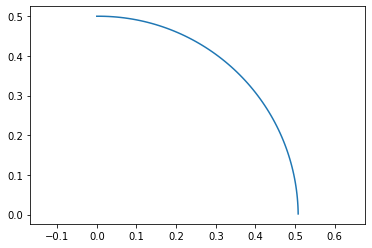

In [9]:
X,Y=simple_contour_naif(f,0.25)
plt.plot(X,Y)
plt.axis("equal")
plt.show()

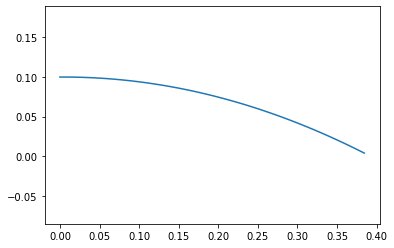

In [10]:
X,Y=simple_contour_naif(g,0.3)
plt.plot(X,Y)
plt.axis("equal")
plt.show()

Le résultat sur des courbes assez régulières est satisfaisant. On constate tout de même que la courbe s'éloigne petit à petit de la ligne de niveau réelle, en particulier dans le cas de la fonction f (norme au carré).

#### Amélioration de la précision de la méthode

Pour palier ce problème on peut utiliser une méthode de Newton en deux dimensions à partir du point $X \in \mathbb{R}^2$ obtenu en suivant l'orthogonal du gradient sur une longueur $\delta$ . On définit ainsi la suite $(X_{k})$ : 
$$X_{0}=X$$
$$X_{k+1}=X_{k}-J^{-1}f(X_{k}).f(X_{k})$$

In [11]:
def Jac(f,x,y):
    j=autograd.jacobian
    return np.c_[j(f,0)(x,y),j(f,1)(x,y)]

La fonction suivante réalise la méthode de Newton en partant d'un point obtenu par tang_norm. Pour être sûr que la fonction termine même lorsque la méthode de Newton ne converge pas on ajoute une condition sur le nombre d'itération.

In [12]:
def recherche_point_newton(f,xi,yi,d,c,eps):
    
    def F(x,y):
        return np.array([f(x,y)-c,(x-xi)**2+(y-yi)**2-d**2])
    
    (x,y)=(xi,yi)+tang_norm(f,xi,yi,d)
    
    it=0 #compte le nombre d'itérations

    while F(x,y)[0]**2+F(x,y)[1]**2 > eps**2 and it<100000:
        J=Jac(F,x,y)
        try:
            (x,y)=(x,y)-np.dot(np.linalg.inv(J),F(x,y))
        except np.linalg.LinAlgError :
            return (x,y)
        it+=1
        
    return (x,y)

In [13]:
def simple_contour(f,c=0.0,d=0.01):
    eps=2**(-25)
    x,y=[],[]
    t=find_seed(f,c)
    if isinstance(t,float):
        x.append(0.0)
        y.append(t)
        (xi,yi)=recherche_point_newton(f,0.0,t,d,c,eps)
        x.append(xi)
        y.append(yi)
        it=0
        while (xi>eps and (1-eps)>xi and yi>eps and (1-eps)>yi) and it <10000:
            (xi,yi)=recherche_point_newton(f,xi,yi,d,c,eps)
            x.append(xi)
            y.append(yi)
            it+=1
        return (np.array(x),np.array(y))
    else:
        return (np.array(x),np.array(x))

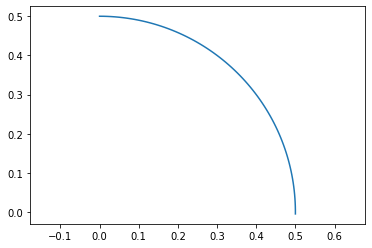

In [14]:
X,Y=simple_contour(f,c=0.25)
plt.plot(X,Y)
plt.axis("equal")
plt.show()

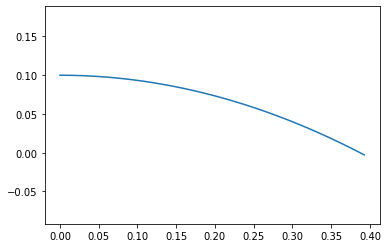

In [15]:
X,Y=simple_contour(g,c=0.3)
plt.plot(X,Y)
plt.axis("equal")
plt.show()

On constate effectivement une amélioration de la précision.

## Contour complexe

On applique une méthode de recherche de racines par dichotomie sur chacun des segments délimitant les cellules.

In [16]:
def find_seed_cellule (g,c,i,j,xc,yc,eps=2**-26):
    """retourne la liste des coordonées des racines trouvées sur les segments délimitant la cellule, si elles existent"""
    seeds=[]
    
    for k in range (0,2):
        a,b=yc[j],yc[j+1]
        if ((g(xc[i+k],yc[j])<=c<=g(xc[i+k],yc[j+1])) or (g(xc[i+k],yc[j+1])<=c<=g(xc[i+k],yc[j]))):
            while (b-a)>eps:
                if g(0,(b+a)/2)>c:
                    b=(b+a)/2
                else:
                    a=(b+a)/2
            seeds.append((xc[i+k],(b+a)/2))
        
        a,b=xc[i],xc[i+1]
        if ((g(xc[i],yc[j+k])<=c<=g(xc[i+1],yc[j+k])) or (g(xc[i+1],yc[j+k])<=c<=g(xc[i],yc[j+k]))):
            while (b-a)>eps:
                if g(0,(b+a)/2)>c:
                    b=(b+a)/2
                else:
                    a=(b+a)/2
            seeds.append(((b+a)/2,yc[j+k]))
            
    return seeds

Dans un premier algorithme on suit simplement l'orthogonal du gradient comme dans contour simple naïf. 

In [17]:
def contour_complexe_naif (g,c=0.0,xc=[0.0,1.0],yc=[0.0,1.0],d=0.01):
    xs,ys=[],[]
    for i in range (0,len(xc)-1):
        for j in range (0,len(yc)-1):
            xs_i_j=[]
            ys_i_j=[]
            seeds=find_seed_cellule (g,c,i,j,xc,yc)
            for (tx,ty) in seeds:
                eps=2**(-10)
                xs_i_j.append(tx)
                ys_i_j.append(ty)
                (xi,yi)=(tx,ty)+tang_norm(f,tx,ty,d)
                it=0
                while (abs(xi-xc[i])>eps and abs(xi-xc[i+1])>eps and abs(yi-yc[j])>eps and abs(yi-yc[j+1])>eps)and it<10000:
                    xs_i_j.append(xi)
                    ys_i_j.append(yi)
                    (xi,yi)=(xi,yi)+tang_norm(f,xi,yi,d)
                    it+=1
            xs.append(xs_i_j)
            ys.append(ys_i_j)
    return (np.array(xs),np.array(ys))

Dans ce deuxième algorithme on suit l'orthogonal du gradient pour trouver un point pour initialiser la méthode de Newton en 2 dimensions (cf contour simple pour les détails).

In [18]:
def contour_complexe (g,c=0.0,xc=[0.0,1.0],yc=[0.0,1.0],d=0.01):
    xs,ys=[],[]
    eps=2**-10
    for i in range (0,len(xc)-1):
        for j in range (0,len(yc)-1):
            xs_i_j=[]
            ys_i_j=[]
            seeds=find_seed_cellule (g,c,i,j,xc,yc)
            for (tx,ty) in seeds:
                xs_i_j.append(tx)
                ys_i_j.append(ty)
                (xi,yi)=(tx,ty)+tang_norm(f,tx,ty,d)
                it=0
                while (abs(xi-xc[i])>eps and abs(xi-xc[i+1])>eps and abs(yi-yc[j])>eps and abs(yi-yc[j+1])>eps) and it<1000:
                    (xi,yi)=recherche_point_newton(f,xi,yi,d,c,eps)
                    xs_i_j.append(xi)
                    ys_i_j.append(yi)
                    it+=1
                xs.append(xs_i_j)
                ys.append(ys_i_j)
    return (np.array(xs),np.array(ys))

### Test des fonctions contour

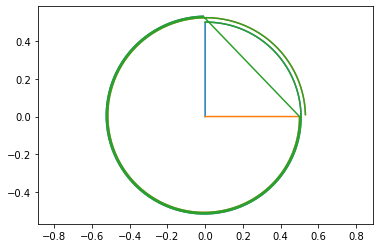

In [28]:
xc=[-1.0, 0.0, 1.0]
yc=[-1.0, 0.0, 1.0]

Xs,Ys=contour_complexe_naif (f,0.25,xc,yc)

for (x,y) in zip(Xs,Ys):
    if len(x)>10:
        plt.plot(x,y)
    
plt.axis("equal")
plt.show()

On constate une accumulation des errreurs qui empêchent le cercle de reboucler sur lui-même.

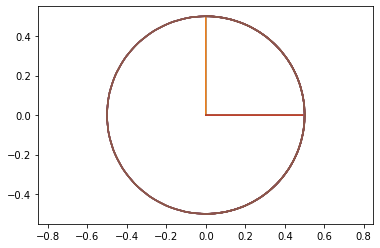

In [29]:
Xs,Ys=contour_complexe (f,0.25,xc,yc)

for (x,y) in zip(Xs,Ys):
    if len(x)>10:
        plt.plot(x,y)
    
plt.axis("equal")
plt.show()

Tandis que dans cette seconde méthode le tracé du cercle est beaucoup plus précis.

#### Fonction contour du professeur

In [31]:
# Rotators
# ------------------------------------------------------------------------------
LEFT, UP, RIGHT, DOWN = 0, 1, 2, 3  # clockwise


def rotate_direction(direction, n=1):
    return (direction + n) % 4


def rotate(x, y, n=1):
    if n == 0:
        return x, y
    elif n >= 1:
        return rotate(1 - y, x, n - 1)
    else:
        assert n < 0
        return rotate(x, y, n=-3 * n)


def rotate_function(f, n=1):
    def rotated_function(x, y):
        xr, yr = rotate(x, y, -n)
        return f(xr, yr)

    return rotated_function


# Complex Contouring
# ------------------------------------------------------------------------------

# Customize the simple_contour function used in contour :
# simple_contour = smart_simple_contour


def contour(f, c, xs=[0.0, 1.0], ys=[0.0, 1.0], delta=0.01):
    curves = []
    nx, ny = len(xs), len(ys)
    for i in range(nx - 1):
        for j in range(ny - 1):
            xmin, xmax = xs[i], xs[i + 1]
            ymin, ymax = ys[j], ys[j + 1]

            def f_cell(x, y):
                return f(xmin + (xmax - xmin) * x, ymin + (ymax - ymin) * y)

            done = set()
            for n in [0, 1, 2, 3]:
                if n not in done:
                    rotated_f_cell = rotate_function(f_cell, n)
                    x_curve_r, y_curve_r = simple_contour(rotated_f_cell, c, delta)
                    exit = None
                    if len(x_curve_r) >= 1:
                        xf, yf = x_curve_r[-1], y_curve_r[-1]
                        if xf == 0.0:
                            exit = LEFT
                        elif xf == 1.0:
                            exit = RIGHT
                        elif yf == 0.0:
                            exit = DOWN
                        elif yf == 1.0:
                            exit = UP
                    if exit is not None:  # a fully successful contour fragment
                        exit = rotate_direction(exit, n)
                        done.add(exit)

                    x_curve, y_curve = [], []
                    for x_r, y_r in zip(x_curve_r, y_curve_r):
                        x, y = rotate(x_r, y_r, n=-n)
                        x_curve.append(x)
                        y_curve.append(y)
                    x_curve = np.array(x_curve)
                    y_curve = np.array(y_curve)
                    curves.append(
                        (xmin + (xmax - xmin) * x_curve, ymin + (ymax - ymin) * y_curve)
                    )
    return curves

In [33]:
level_curves=contour(f,0.25)

for x, y in level_curves:
    plt.plot(x, y)


KeyboardInterrupt: 